In [1]:
import bilby
import sys
sys.path.append('../')
import numpy as np
from bilby.core.utils import ra_dec_to_theta_phi, speed_of_light
from bilby.core.utils.constants import *
import bilby.gw.utils as gwutils
from copy import deepcopy
from scipy.stats import multivariate_normal
from gw_analysis import *
import matplotlib.pyplot as plt
import h5py

In [2]:
snr_threshold = 300

In [3]:
#Read the file ../BBH_samples.h5 using h5py
with h5py.File('../bbh_samples.h5', 'r') as file:
    chirp_mass = file['detector_frame_chirp_mass'][:]
    q = file['q'][:]
    chi_1 = file['chi_1'][:]
    chi_2 = file['chi_2'][:]
    luminosity_distance = file['luminosity_distance'][:]
    dec = file['dec'][:]
    ra = file['ra'][:]
    geocent_time = file['geocentric_time'][:]
    phase = file['phase'][:]
    psi = file['psi'][:]
    theta_jn = file['theta_jn'][:]
    snr = np.sqrt(file['snr_A1'][:] ** 2 + file['snr_CE20km_1p5MW_Aplus_coat_flow_5'][:] ** 2 + file['snr_CE40km_1p5MW_Aplus_coat_flow_5'][:] ** 2)
    duration = file['duration_CE40km_1p5MW_Aplus_coat_flow_5'][:]
    start_time = file['start_time_CE40km_1p5MW_Aplus_coat_flow_5'][:]


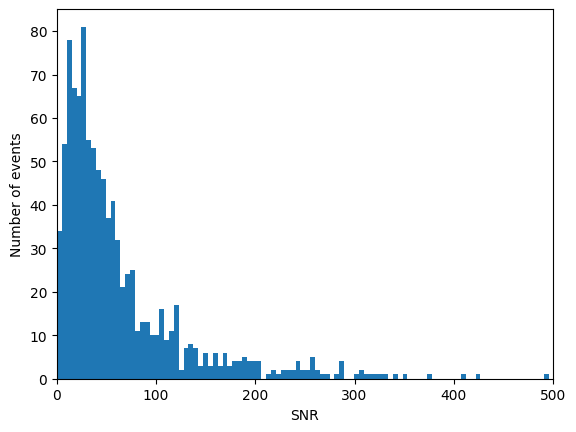

In [4]:
plt.hist(snr, bins=500);
plt.xlim(0, 500);
plt.xlabel('SNR');
plt.ylabel('Number of events');

In [5]:
waveform_minimum_frequency = 5 # do not change this
detector_minimum_frequency = 5 # change
sampling_frequency = 4096
reference_frequency = 100
tc_offset = 1
waveformname = "IMRPhenomXPHM"

e_dict = dict(
    chirp_mass=1e-7, mass_ratio=1e-5, chi_1=1e-5, chi_2=1e-5,
    ra=1e-5, dec=1e-5, luminosity_distance = 1e-5,
    theta_jn=1e-5, psi=1e-5, phase=1e-5, geocent_time=1e-5, A = 1e-5
)

In [6]:
N = 1000
CE40km_1p5MW_asd_file = '../../asd/CE40km_1p5MW_Aplus_coat_strain.txt'
CE20km_1p5MW_asd_file = '../../asd/CE20km_1p5MW_Aplus_coat_strain.txt'
A1_asd_file = '../../asd/Aplus_asd.txt'
CE40_detector = '../../detector_configurations/bilby/CE40.ifo'
detector_minimum_frequency = 5
mode_array = [[2,2], [3,2], [3,3], [4,4]]

In [7]:

for i in range(N):
    if i % 1000 == 0:
        print(f'Processing event {i}/{len(snr)}')
    if snr[i] < snr_threshold:
        continue
    print(f'Event {i} with SNR {snr[i]}')

    

    injection_parameters = dict(
    chirp_mass=chirp_mass[i],
    mass_ratio=q[i],
    chi_1=chi_1[i],
    chi_2=chi_2[i],
    ra=ra[i],
    dec=dec[i],
    luminosity_distance=luminosity_distance[i],  
    theta_jn=theta_jn[i],
    psi=psi[i],
    phase=phase[i],
    geocent_time=geocent_time[i],
    a=0, A=0)

    # Use shared setup function
    ifo_CE40, waveform_generator, duration, start_time = setup_detector_and_waveform_generator(
        injection_parameters, CE40km_1p5MW_asd_file, CE40_detector, waveform_minimum_frequency, 
        sampling_frequency, reference_frequency, 'IMRPhenomXPHM', mode_array
    )
    
    ifo_CE40.minimum_frequency = detector_minimum_frequency

    xG_effects = ['False', 'False', 'True']
    
    # Use calc_waveform to get the strain
    frequencies, h = calc_waveform(
        ifo_CE40, waveform_minimum_frequency, injection_parameters, 
        waveform_generator, sampling_frequency, xG_effects
    )
    
    # Calculate SNR from strain
    ifo_CE40.set_strain_data_from_frequency_domain_strain(
        h, start_time=start_time, frequency_array=frequencies
    )

    Fisher_CE40_1p5MW = calc_Fisher(h, frequencies, ifo_CE40, waveform_minimum_frequency, injection_parameters, waveform_generator, [False,False,True], e_dict, skip=['a', 'H0'])

    ifo_CE20, waveform_generator, duration, start_time = setup_detector_and_waveform_generator(
        injection_parameters, CE20km_1p5MW_asd_file, CE40_detector, waveform_minimum_frequency, 
        sampling_frequency, reference_frequency, 'IMRPhenomXPHM', mode_array
    )
    ifo_CE20.minimum_frequency = detector_minimum_frequency
    frequencies, h = calc_waveform(
        ifo_CE20, waveform_minimum_frequency, injection_parameters, 
        waveform_generator, sampling_frequency, xG_effects
    )
    ifo_CE20.set_strain_data_from_frequency_domain_strain(
        h, start_time=start_time, frequency_array=frequencies
    )
    Fisher_CE20_1p5MW = calc_Fisher(h, frequencies, ifo_CE20, waveform_minimum_frequency, injection_parameters, waveform_generator, [False,False,True], e_dict, skip=['a', 'H0'])

   
    ifo_A1, waveform_generator, duration, start_time = setup_detector_and_waveform_generator(
        injection_parameters, A1_asd_file, CE40_detector, waveform_minimum_frequency, 
        sampling_frequency, reference_frequency, 'IMRPhenomXPHM', mode_array
    )
    ifo_A1.minimum_frequency = 20
    frequencies, h = calc_waveform(
        ifo_A1, waveform_minimum_frequency, injection_parameters, 
        waveform_generator, sampling_frequency, xG_effects
    )
    ifo_A1.set_strain_data_from_frequency_domain_strain(
        h, start_time=start_time, frequency_array=frequencies
    )
    Fisher_A1 = calc_Fisher(h, frequencies, ifo_CE20, waveform_minimum_frequency, injection_parameters, waveform_generator, [False,False,True], e_dict, skip=['a', 'H0'])

    import os 
    os.makedirs('CE40_1p5MW_flow_5', exist_ok=True)
    np.savez_compressed(f'CE40_1p5MW_flow_5/{i}.npz', Fisher=Fisher_CE40_1p5MW)

    os.makedirs('CE20_1p5MW_flow_5', exist_ok=True)
    np.savez_compressed(f'CE20_1p5MW_flow_5/{i}.npz', Fisher=Fisher_CE20_1p5MW)

    os.makedirs('A1', exist_ok=True)
    np.savez_compressed(f'A1/{i}.npz', Fisher=Fisher_A1)



    

Processing event 0/100000
Event 166 with SNR 308.7657556098904


/Users/pbaral/Documents/Research/bilby-x-g/bilby/gw/source.py:622: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/Users/pbaral/Documents/Research/bilby-x-g/bilby/gw/detector/interferometer.py:483: RuntimeWarning: divide by zero encountered in scalar power
  lambda_A = h * np.abs(A) ** (1/(a-2))


Event 226 with SNR 333.3730091207021
Event 243 with SNR 301.38732817393264
Event 279 with SNR 320.8488231992246
Event 286 with SNR 520.3038590440115
Event 296 with SNR 316.7585912787074
Event 386 with SNR 423.45741396011596
Event 416 with SNR 2452.6342571879154
Event 418 with SNR 324.86585000745595
Event 505 with SNR 350.1823878106267
Event 586 with SNR 375.83502641305
Event 648 with SNR 411.6375437989003
Event 781 with SNR 338.9302202532029
Event 786 with SNR 306.10891150519745
Event 814 with SNR 492.431960920452
Event 928 with SNR 677.9791203364567
Event 965 with SNR 1420.3093295885426
Event 975 with SNR 309.28123339248447


In [31]:
#Read the files CE40_1p5MW_flow_5/{i}.npz, CE20_1p5MW_flow_5/{i}.npz, A1/{i}.npz and print the Fisher matrices
sigma_A_squared = 0
snr_threshold = 1000
for i in range(N):
    if i % 1000 == 0:
        print(f'Loading event {i}/{N}')
    if snr[i] < snr_threshold:
        continue
    Fisher_CE40_1p5MW = np.load(f'CE40_1p5MW_flow_5/{i}.npz')['Fisher']
    Fisher_CE20_1p5MW = np.load(f'CE20_1p5MW_flow_5/{i}.npz')['Fisher']
    Fisher_A1 = np.load(f'A1/{i}.npz')['Fisher']

     #remove phase
    # Fisher_CE40_1p5MW = remove(Fisher_CE40_1p5MW, 6)
    # Fisher_CE20_1p5MW = remove(Fisher_CE20_1p5MW, 6)
    # Fisher_A1 = remove(Fisher_A1, 6)

    Fisher_CE40_1p5MW_CE20_1p5MW_A1 = Fisher_CE40_1p5MW + Fisher_CE20_1p5MW + Fisher_A1
    Covariance_matrix = np.linalg.inv(Fisher_CE40_1p5MW_CE20_1p5MW_A1)
    #print(len(Covariance_matrix))

    


    # Check Fisher_CE40_1p5MW_CE20_1p5MW_A1@Covariance_matrix is close to identity matrix
    identity_matrix = Fisher_CE40_1p5MW_CE20_1p5MW_A1@Covariance_matrix
    # plt.imshow(identity_matrix)
    # plt.show()
     # Check if identity_matrix is close to identity matrix
    if not np.allclose(identity_matrix, np.eye(len(identity_matrix)), atol=1e-1):
        print(f'Warning: Fisher matrix inversion failed for event {i}, snr {snr[i]}')
    else:
        sigma_A_squared = 1/Covariance_matrix[-1,-1]
    sigma_A = np.sqrt(sigma_A_squared)

print(f'Sigma_A: {sigma_A}')



Loading event 0/1000
Sigma_A: 0.007137070876865955


In [29]:
sigma_A

np.float64(0.007137070876865955)